
# Training a Classifier in PyTorch

![classifier](notebook_diagrams/pytorch_classifier.png)

Now that we've worrked through the mechanics of how PyTorch works, we're ready to train our own neural network to classify images!  The reference for this notebook can be found [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-an-image-classifier).

Now you might be thinking...

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV, and NumPy are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, PyTorch has created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing "boilerplate" code.

For this tutorial, we will use the CIFAR10 dataset.
It has ten classes: 

* ’airplane’
* ‘automobile’
* ‘bird’
* ‘cat’
* ‘deer’
* ‘dog’
* ‘frog’
* ‘horse’
* ‘ship’
* ‘truck’

The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.  Example images from this dataset are shown below:

![CIFAR](notebook_diagrams/cifar10.png)

## Overview: How will We Train this Classifier?

To train our image classifier, we will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using torchvision

2. Define a Convolutional Neural Network

3. Define a loss function

4. Train the network on the training data

5. Test the network on the test data

## 0. Installation Block
Let's first install PyTorch, and then import what we need from pytorch and torchvision.

### 0.1 Installation Block
We'll use Anaconda to install PyTorch on our AWS machines for this tutorial.  If you don't want to install this package through Anaconda, you can also do so through `pip`.

In [ ]:
# Activate conda environment
! conda activate local_env

# Install PyTorch in Conda environment
! conda install -c pytorch pytorch
! pip install torchvision

# Check PyTorch version
! pip show torch

# Use matplotlib inline version
%matplotlib inline

### 0.2 Import Block

In [2]:
# Use for formatting plots
%matplotlib inline

# Import pytorch package and modules for vision
import torch
import torchvision
import torchvision.transforms as transforms

# Import other packages for numerical computation and plotting
import matplotlib.pyplot as plt
import numpy as np

## 1. Image Data Pre-Processing
Like other problems we've analyzed in computer vision, it's really important that we pre-process our image data in a way that results in optimal and efficient training for our neural network.

The output of torchvision datasets are `PILImage` image objects, with values ranging from `[0, 1]`.  For our network, we will standardize these tensors to be in the normalized range `[-1, 1]` using the `torchvision.transforms` module..

**NOTE**: If you are running on Windows and you get a BrokenPipeError, try setting the `num_worker` of `torch.utils.data.DataLoader()` to 0.

### 1.1 Create Normalized Training and Testing Datasets and Dataloaders
We will use the transform framework described above, as well as the PyTorch [DataLoader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) object, which is an efficient way to create customizable and augmented datasets.

In [3]:
# Define our PyTorch transform - often these numbers are standardized and easy to find online
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Use torchvision to extract training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# DataLoaders are another important part of PyTorch - they are similar to the generators we saw with Keras
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

# Use torchvision to extract test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Define DataLoader for test data
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

# Define labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

97.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### 1.2 Visualize Training Data
Depending on your vision application, displaying your data may be helpful to gain a better intuition for what models to use/why a network will/not work well.

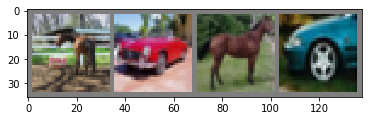

horse   car horse   car


In [4]:
# Function for showing un-normalized image
def imshow(img):
    # Un-normalize the iamge
    img = img / 2 + 0.5     
    
    # Convert to numpy
    npimg = img.numpy()
    
    # Plot image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define Our Model: CNN
For this image classifier, we'll be using a Convolutional Neural Network (CNN) to classify our images, since again these models preserve local structure in an image better than standard fully connected networks.  Recall with defining neural network models in PyTorch that we need to define two functions/class methods:

1.  `__init__` (called the constructor) - Make sure this inherits from the `nn.Module` class by calling `super(Net, self).__init__()`.


2.  `forward` - This is the method that tells the neural network how it will make predictions.

In [5]:
# PyTorch-specific imports
import torch.nn as nn
import torch.nn.functional as F

# Class definition for our neural network
class Net(nn.Module):
    
    # Constructor method
    def __init__(self):
        
        # Class inherits from nn.Module
        super(Net, self).__init__()
        
        # Now add custom layers - start with convolution layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Now add fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    # Forward method for prediction
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Make an instance of our classifier network
net = Net()

## 3. Define a Loss Function and Optimizer
Remember that in order to train a model, the model needs to have a way for its performance to be evaluated (a **loss function**), as well as a way that tells the computer how we'll train and update the parameters in our model (an **optimizer**).

Since this is a classification problem, let's use **Cross-Entropy** for our loss function and **ADAM** for our optimizer.

In [7]:
# Import the PyTorch optimizer module
import torch.optim as optim

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

## 4. Train Our Image Classification Network
We'll combine our `DataLoaders`, `Net`, `criterion`, and `optimizer` objects above to train our neural network to classify objects in the CIFAR-10 dataset.

### 4.1 Training Loop for Our Model

In [8]:
# Define how many epochs we train over
EPOCHS = 2

# Loop over the dataset multiple times
for epoch in range(EPOCHS): 
    
    # Keep track of loss
    running_loss = 0.0
    
    # Iterate over trainloader
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.872
[1,  4000] loss: 1.623
[1,  6000] loss: 1.538
[1,  8000] loss: 1.479
[1, 10000] loss: 1.413
[1, 12000] loss: 1.399
[2,  2000] loss: 1.313
[2,  4000] loss: 1.319
[2,  6000] loss: 1.288
[2,  8000] loss: 1.266
[2, 10000] loss: 1.275
[2, 12000] loss: 1.247
Finished Training


### 4.2 Save Our Trained Model
Let's quickly save our trained model.  When training over extended periods of time, it is often advisable to train in a `tmux` or `screen` session (easy to install if using an Ubuntu/Linux-based AWS instance), and to save your model after every couple of epochs.

For more information on how to save models, see the link [here](https://pytorch.org/docs/stable/notes/serialization.html).

In [9]:
# Save fpath
PATH = './cifar_net.pth'

# Save the trained model
torch.save(net.state_dict(), PATH)

## 5. Evaluate and Test the Network
We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learned anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

### 5.1 Analyze Test Data

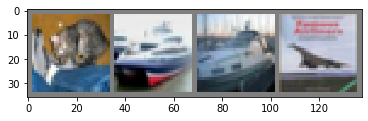

GroundTruth:    cat  ship  ship plane


In [10]:
# Define iterator object
dataiter = iter(testloader)

# Get images and labels from iterator object
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 5.2 Load Saved Model for Making Predictions
Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [11]:
# Create a new neural network
net = Net()

# Load saved weights
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### 5.3 Make Predictions for Neural Network
Okay, now let us see what the neural network thinks these examples above are:

In [12]:
# Make predictions on all images from iterator
outputs = net(images)

The outputs are energies/logits (depending on your interpretation; technically both of these are correct) for the 10 classes.  The higher the energy for a class, the more the network thinks that the image is of the particular class.  So, let's get the index of the highest energy, which is the class the network thinks is the most likely:

In [13]:
# Get highest-predicted classes
_, predicted = torch.max(outputs, 1)

# Show these
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  ship  ship plane


### 5.4 Make Predictions on Whole Dataset
Now that we've evaluated performance on a subset of the test dataset, let's look at how our models does with the entire thing.

In [14]:
# Set counters
correct = 0
total = 0

# Use the line below for "evaluation"
with torch.no_grad():
    
    # Iterate over test data
    for data in testloader:
        
        # Get data and make predictions
        images, labels = data
        outputs = net(images)
        
        # Hard assignment of the predicted class
        _, predicted = torch.max(outputs.data, 1)
        
        # Updated counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


That looks way better than chance, (in this case, chance is 10% accuracy (randomly picking
a class out of 10 classes)).  Our network did a pretty good job of learning!

Another important aspect of evaluation is looking specifically at classes the neural network did a good job classifying, as well as classes the neural network did not do so well on.

In [15]:
# Counters for specific classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Make sure we aren't making weight updates
with torch.no_grad():
    
    # Iterate over test data
    for data in testloader:
        
        # Get data and make predictions
        images, labels = data
        outputs = net(images)
        
        # Hard assignment of class
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        # Update class-specific counters
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Display accuracies for all ten labels
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 53 %
Accuracy of   car : 55 %
Accuracy of  bird : 38 %
Accuracy of   cat : 23 %
Accuracy of  deer : 53 %
Accuracy of   dog : 59 %
Accuracy of  frog : 60 %
Accuracy of horse : 60 %
Accuracy of  ship : 73 %
Accuracy of truck : 68 %


## 6. Exercise: Try Increasing the Overall Accuracy of This Network!
You have many options for how you can improve the overall performance of this network.  These include, but are not limited to:

- Changing the architecture of the network
- Changing the learning rate
- Changing the optimizer
- Changing how long we train for (epochs)

Try experimenting with these to see if you can improve classification performance.  The code from above has been copy/pasted below - please make your desired modifications **below**.

### 6.1 Your Network Architecture
Make any changes to your neural network architecture below.  These modifications could be:

- Changing the number, types, or size of different layers (in the `__init__` method).
- Changing how the input is mapped to the output (in the `forward` method).

In [17]:
# PyTorch-specific imports
import torch.nn as nn
import torch.nn.functional as F

# Class definition for our neural network
class BetterNet(nn.Module):
    
    # Constructor method
    def __init__(self):
        
        # Class inherits from nn.Module
        super(BetterNet, self).__init__()
        
        # Now add custom layers - start with convolution layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Now add fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    # Forward method for prediction
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Make an instance of our classifier network
net = BetterNet()

### 6.2 Define Your Optimizer, Learning Rate, and Epochs
Modify these training parameters below to adjust how your network will be trained.

In [19]:
####################################
# DON'T CHANGE THIS
# Define loss function
criterion = nn.CrossEntropyLoss()
# DON'T CHANGE THIS
####################################

# Define learning rate and optimizer
learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Define number of epochs
epochs = 10

### 6.3 Train and Evaluate on Your Modified Network
Now that we've changed your network and parameters for training it, let's train and evaluate it to see if our performance improves!

In [ ]:
# CODE FOR TRAINING
for epoch in range(epochs): 
    
    # Keep track of loss
    running_loss = 0.0
    
    # Iterate over trainloader
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

            
print('Finished Training')

# CODE FOR EVALUATION
# Set counters
correct = 0
total = 0

# Use the line below for "evaluation"
with torch.no_grad():
    
    # Iterate over test data
    for data in testloader:
        
        # Get data and make predictions
        images, labels = data
        outputs = net(images)
        
        # Hard assignment of the predicted class
        _, predicted = torch.max(outputs.data, 1)
        
        # Updated counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# CODE FOR CLASS-SPECIFIC EVALUATION
# Counters for specific classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Make sure we aren't making weight updates
with torch.no_grad():
    
    # Iterate over test data
    for data in testloader:
        
        # Get data and make predictions
        images, labels = data
        outputs = net(images)
        
        # Hard assignment of class
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        # Update class-specific counters
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Display accuracies for all ten labels
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

How did your network do?  Can you think why?

## 7. (Optional) Training on GPU

Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [ ]:
# Check if there is CUDA available, and if so display CUDA-enabled device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print("CUDA device is: %s" % (device))

## 8. (Optional) Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out [data_parallel_tutorial](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html).
